<a href="https://colab.research.google.com/github/sathvik-ujwal/Credit-Card-Fraud-Detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from collections import Counter


#Loading dataset

In [ ]:
try:
  raw_df = pd.read_csv('/home/sathvik/Documents/Datasets/creditcard.csv')
except:
  raw_df =pd.read_csv('creditcard.csv')

raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


#Checking imbalance in data


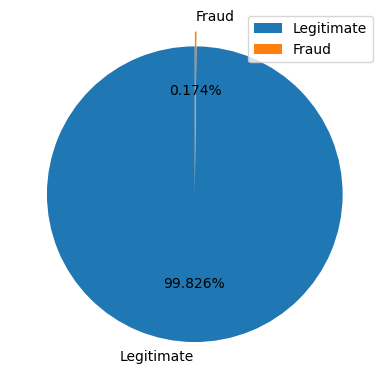

In [44]:
Labels = ["Legitimate", "Fraud"]
Label_count = raw_df["Class"].value_counts().tolist()
explode = [0, 0.1]

plt.pie(Label_count, labels=Labels, autopct='%1.3f%%', explode=explode, startangle = 90)
plt.legend(loc="upper right")
plt.show()

In [48]:
print(f"Number of Legitimate Transactions: {Label_count[0]}")
print(f"Number of Fraudulent Transactions: {Label_count[1]}")

Number of Legitimate Transactions: 282652
Number of Fraudulent Transactions: 492


#Data preprocessing


##Deleting duplicate values

In [50]:
df = raw_df.copy()
df.drop(['Time'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

##Checking for outliers

###Using boxplot


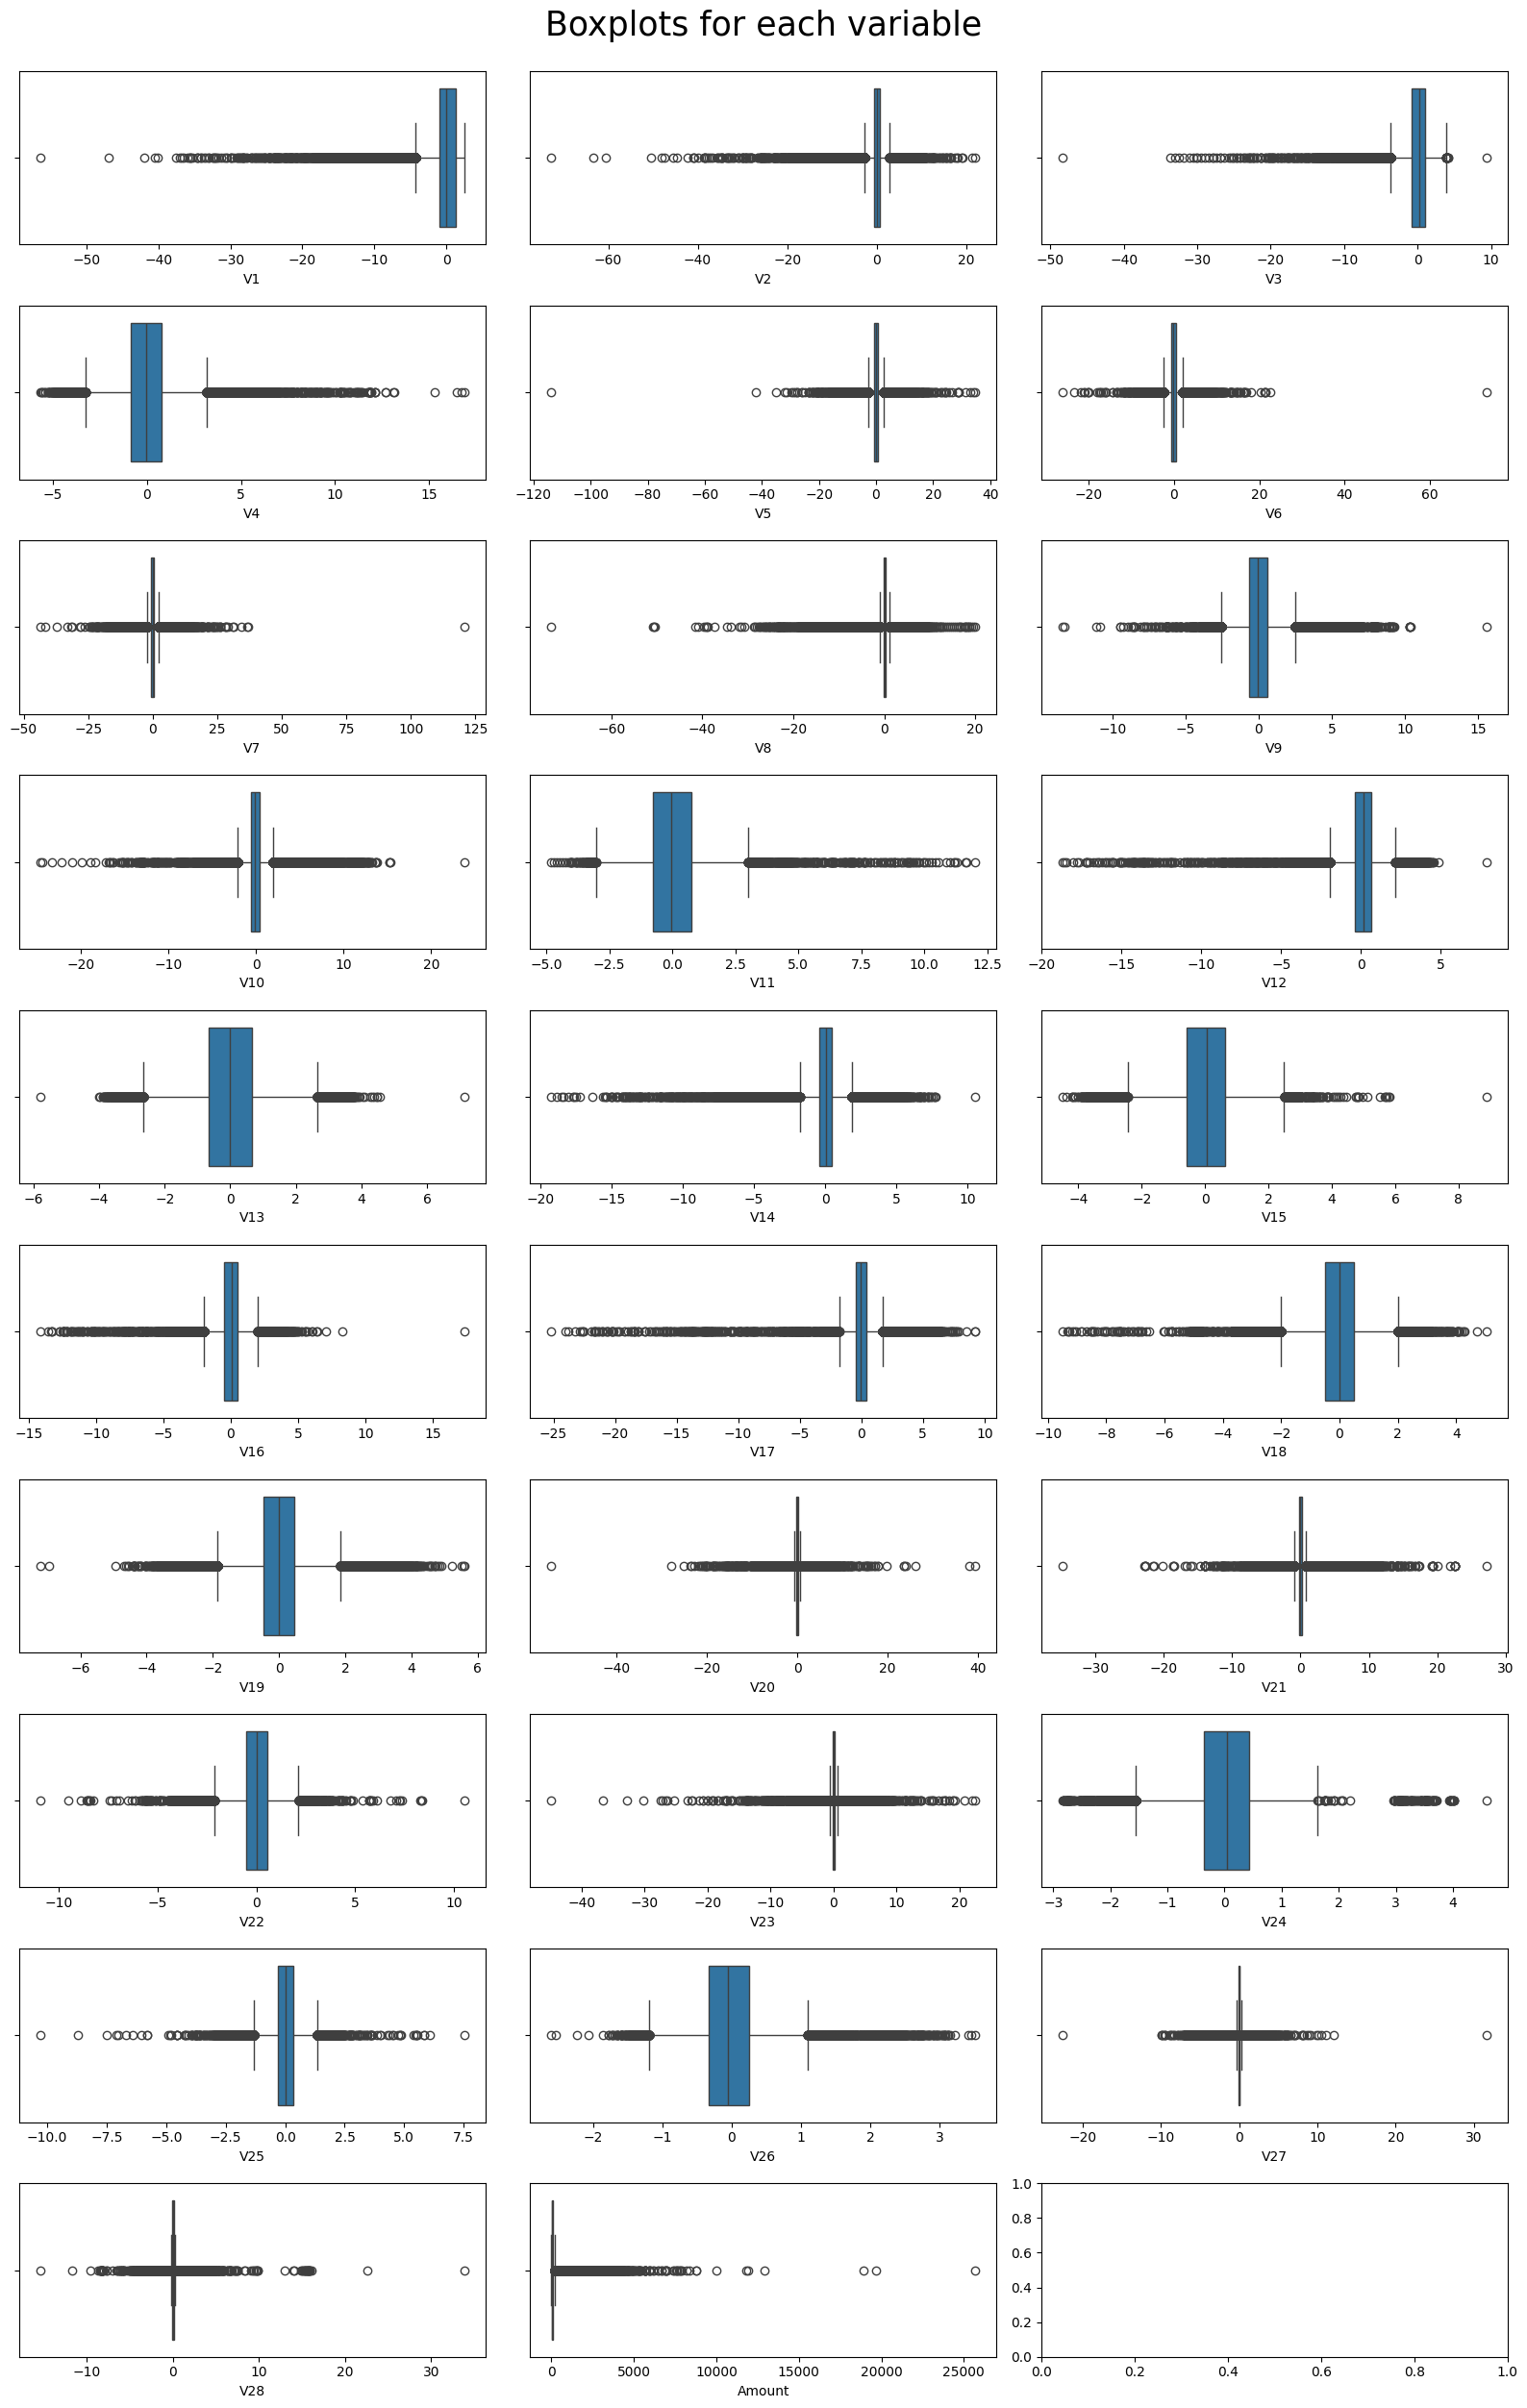

In [53]:
fig, axes = plt.subplots(10, 3, figsize=(16, 25))
fig.suptitle('Boxplots for each variable', y = 1, size = 25)

for i, column in enumerate(df.columns[:-1]):
    sns.boxplot(x=df[column], ax=axes[i // 3, i % 3])

plt.tight_layout()
plt.show()
